XGBoost is an ensamble technique that works with extreme gradient boosting. It utilizes decision trees as base learners and employs regularization techniques to enhance model generalization.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import datasets
X_train = pd.read_csv('/Users/alessia/Desktop/churn/X_train.csv')
y_train = pd.read_csv('/Users/alessia/Desktop/churn/y_train.csv')
X_test = pd.read_csv('/Users/alessia/Desktop/churn/X_test.csv')
y_test = pd.read_csv('/Users/alessia/Desktop/churn/y_test.csv')

In [3]:
# parameter grid to search
param_grid = {
    'max_depth' : [2, None],
    'learning_rate' : [1.0, 2.0],
}

# classifier
bst = XGBClassifier(n_estimators=2, objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(estimator=bst, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel()) 

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: {:.4f}".format(grid_search.best_score_))

Best Parameters:  {'learning_rate': 1.0, 'max_depth': None}
Best AUC: 0.8830


In [4]:
XGBoost = grid_search.best_estimator_ # select best estimator based on best parameters

# refit model on training set
XGBoost.fit(X = X_train, y = y_train.values.ravel())

# predict on the training set
y_pred_train = XGBoost.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# AUC on training set
y_probs_train = XGBoost.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_test = XGBoost.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# AUC on test set
y_probs_test = XGBoost.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8617
AUC on training set is 0.8850992807758421
Accuracy on test set: 0.8598
AUC on test set is 0.8835481036324787


In [5]:
# confusion matrix
classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='YlOrBr', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

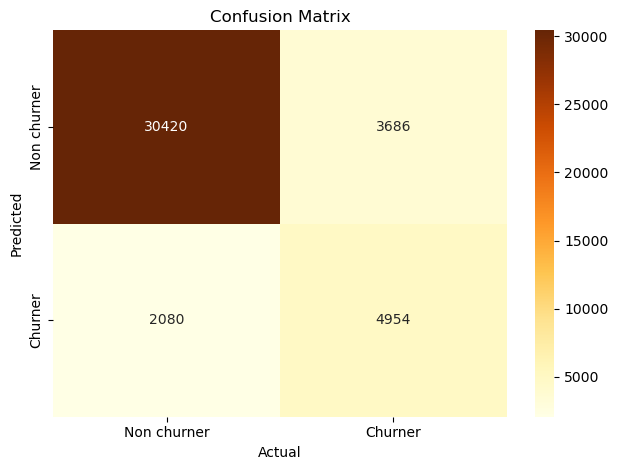

In [6]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_test,y_test)

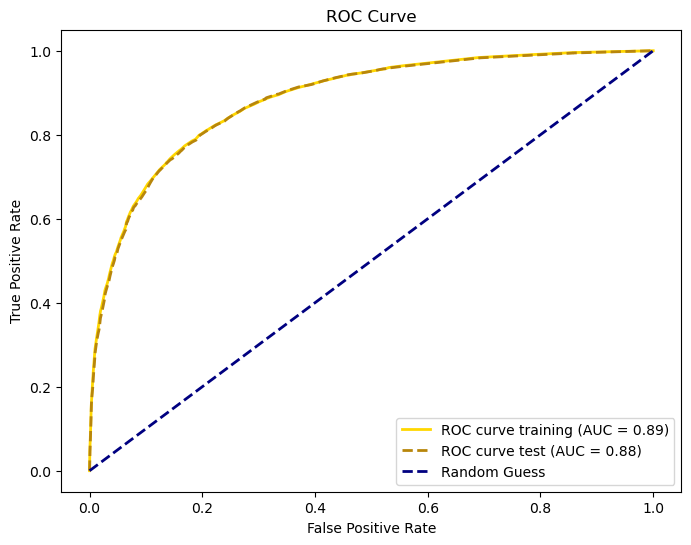

In [7]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='gold', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'darkgoldenrod', linestyle='--', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test = precision_score(y_test, y_pred_test)
# recall
recall_test = recall_score(y_test, y_pred_test)
# f1-measure
f1_test = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test))
print('Recall on the test set is {}'.format(recall_test))
print('f1-measure on the test set is {}'.format(f1_test))

Precision on the test set is 0.7042934319021894
Recall on the test set is 0.5733796296296296
f1-measure on the test set is 0.6321296414444303


In [9]:
# save model
model_name='XGBoost.pkl'
model_file=open(model_name,'wb')
pickle.dump(XGBoost, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)